In [1]:
%cd ..

/home/oleg


In [51]:
# type: ignore

import typing
from typing import Any, cast

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import numpy.typing as npt
import pandas as pd

from asr_eval.streaming.sender import StreamingAudioSender
from asr_eval.streaming.caller import transсribe_parallel
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import TranscriptionChunk
from asr_eval.streaming.evaluation import get_word_timings, get_partial_alignments, remap_time
from asr_eval.streaming.plots import partial_alignment_diagram, visualize_history

In [52]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [ ]:
# type: ignore

dataset: Dataset = load_dataset('bond005/podlodka_speech')['test'].skip(3).take(1)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
df = pd.DataFrame(list(dataset))

def get_streaming_sender(id: str, audio: dict[str, Any]) -> dict[str, Any]:
    return StreamingAudioSender(
        id=id,
        audio=np.int16(audio['array'] * 32768).tobytes(),
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        verbose=False,
    )

df['id'] = df.audio.apply(lambda audio: audio['path'])
df['sender'] = df.apply(lambda row: get_streaming_sender(row.id, row.audio), axis=1)

In [28]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()
results = transсribe_parallel(asr=asr, senders=df.sender, n_threads=1, send_all_without_delays=True)
asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

Transcribing sound_test_0004.wav
Transcribed sound_test_0004.wav: да это отсутствие долго живущие бранчей другими словами отсутствие какому- [...]


In [29]:
# type: ignore

df['preds'] = [TranscriptionChunk.join(x) for x in results.values()]

jiwer.wer(reference=df['transcription'].tolist(), hypothesis=df['preds'].tolist())

0.5625

In [6]:
# TODO защита против нескольких транскрипций

[InputChunk(data=b'', start_time=0, end_time=0.2, put_timestamp=1750082699.4011192, get_timestamp=1750082699.4022226),
 InputChunk(data=b'', start_time=0.2, end_time=0.4, put_timestamp=1750082699.4011593, get_timestamp=1750082699.4022324),
 InputChunk(data=b'', start_time=0.4, end_time=0.6000000000000001, put_timestamp=1750082699.401168, get_timestamp=1750082699.4022408),
 InputChunk(data=b'', start_time=0.6000000000000001, end_time=0.8, put_timestamp=1750082699.4011781, get_timestamp=1750082699.4022737),
 InputChunk(data=b'', start_time=0.8, end_time=1.0, put_timestamp=1750082699.4011924, get_timestamp=1750082699.4022892)]

[OutputChunk(data=TranscriptionChunk(uid='1f99e610-c1cd-4699-af96-5fc8f3f5f132', text=''), seconds_processed=1.0, put_timestamp=1750082699.467216, get_timestamp=1750082699.4673424),
 OutputChunk(data=TranscriptionChunk(uid='1f99e610-c1cd-4699-af96-5fc8f3f5f132', text=''), seconds_processed=2.0, put_timestamp=1750082699.7913213, get_timestamp=1750082699.7914512),
 OutputChunk(data=TranscriptionChunk(uid='1f99e610-c1cd-4699-af96-5fc8f3f5f132', text='да это отсутствие'), seconds_processed=3.0, put_timestamp=1750082700.1245196, get_timestamp=1750082700.1246457),
 OutputChunk(data=TranscriptionChunk(uid='1f99e610-c1cd-4699-af96-5fc8f3f5f132', text='да это отсутствие долго живущие бранчей'), seconds_processed=4.0, put_timestamp=1750082700.5279818, get_timestamp=1750082700.5281196),
 OutputChunk(data=TranscriptionChunk(uid='1f99e610-c1cd-4699-af96-5fc8f3f5f132', text='да это отсутствие долго живущие бранчей другими словами открой'), seconds_processed=5.0, put_timestamp=1750082700.9421852, get

[PartialAlignment(alignment=MatchesList(matches=[(да, ), (это, )], total_true_len=2, score=AlignmentScore(n_word_errors=2, n_correct=0, n_char_errors=5)), audio_seconds_sent=1.0, audio_seconds_processed=1.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(да, ), (это, ), (отсутствие, ), (долго, ), (живущих, )], total_true_len=5, score=AlignmentScore(n_word_errors=5, n_correct=0, n_char_errors=27)), audio_seconds_sent=2.2, audio_seconds_processed=2.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(да, да), (это, это), (отсутствие, отсутствие), (долго, ), (живущих, ), (бранчей, ), (другими, )], total_true_len=7, score=AlignmentScore(n_word_errors=4, n_correct=3, n_char_errors=26)), audio_seconds_sent=3.2, audio_seconds_processed=3.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(да, да), (это, это), (отсутствие, отсутствие), (долго, долго), (живущих, живущие), (бранчей, бранчей), (другими, ), (словами,

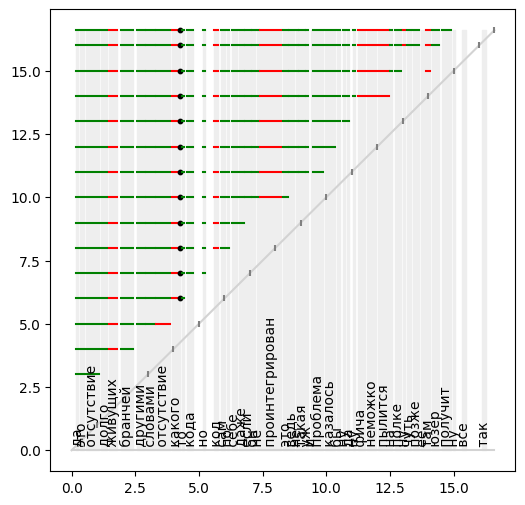

In [30]:
sample = df.iloc[0] # type: ignore
waveform = cast(npt.NDArray[np.floating], sample['audio']['array'])
text = cast(str, sample['transcription'])
sender = cast(StreamingAudioSender, sample.sender) # type: ignore
input_chunks = sender.history
output_chunks = results[sample['id']]
cutoffs = sender.get_send_times()

word_timings = get_word_timings(gigaam_model, waveform, text)

input_chunks_remapped, output_chunks_remapped = remap_time(cutoffs, input_chunks, output_chunks)

partial_alignments = get_partial_alignments(input_chunks_remapped, output_chunks_remapped, word_timings, processes=1) # type: ignore

# visualize_history(input_chunks, output_chunks)
# visualize_history(input_chunks_remapped, output_chunks_remapped)

display(input_chunks[:5])
display(output_chunks[:5])
display(partial_alignments[:5])

assert input_chunks[-1].end_time is not None

partial_alignment_diagram(
    partial_alignments,
    word_timings,
    audio_len=input_chunks[-1].end_time,  # TODO: may be not precise
    figsize=(6, 6),
    y_type='processed',
)

In [38]:
from typing import Literal

from asr_eval.align.data import Match, Token

stats: list[tuple[float, Literal['correct', 'error', 'not_yet']]] = []

def get_center_time(token: Token):
    return (token.start_time + token.end_time) / 2

# TODO find a better way
partial_alignments[-1].audio_seconds_processed = partial_alignments[-2].audio_seconds_processed

for partial_alignment in partial_alignments:
    # split into head and tail
    head: list[Match] = []
    tail: list[Match] = []
    in_tail = True
    for match in partial_alignment.alignment.matches[::-1]:
        in_tail &= match.status == 'deletion'
        if in_tail:
            tail.insert(0, match)
        else:
            head.insert(0, match)
            
    sec_processed = cast(float, partial_alignment.audio_seconds_processed)
    
    # process head
    for i, match in enumerate(head):
        if match.status == 'correct':
            for token in match.true:
                stats.append((sec_processed - get_center_time(token), 'correct'))
        elif match.status == 'insertion':
            left_pos = max(
                [0] + [token.end_time for match2 in head[:i] for token in match2.true]
            )
            right_pos = min(
                [sec_processed] + [token.end_time for match2 in head[i + 1:] for token in match2.true]
            )
            stats.append((sec_processed - (left_pos + right_pos) / 2, 'error'))
        else:
            for token in match.true:
                stats.append((sec_processed - get_center_time(token), 'error'))
    
    # process tail
    for match in tail:
        for token in match.true:
            stats.append((sec_processed - get_center_time(token), 'not_yet'))


counts: dict[Literal['correct', 'error', 'not_yet'], npt.NDArray[np.int64]] = {}

bins = [0, 1, 2, 3, 5, 10, 1000]
for status in 'correct', 'error', 'not_yet':
    counts[status] = np.histogram([t for t, s in stats if s == status], bins=bins)[0]

total_counts = sum(counts.values())

ratios = {status: c / total_counts for status, c in counts.items()}
ratios

{'correct': array([0.        , 0.24074074, 0.66666667, 0.74725275, 0.81065089,
        0.79775281]),
 'error': array([0.        , 0.18518519, 0.31372549, 0.25274725, 0.18934911,
        0.20224719]),
 'not_yet': array([1.        , 0.57407407, 0.01960784, 0.        , 0.        ,
        0.        ])}

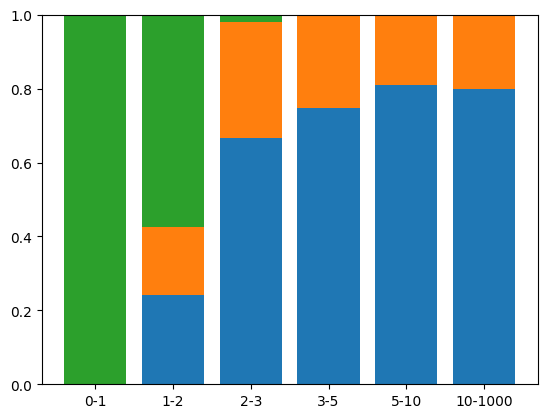

In [ ]:
from itertools import pairwise
import matplotlib.pyplot as plt

xrange = range(len(bins) - 1)
plt.bar(xrange, height=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['error'], bottom=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['not_yet'], bottom=ratios['correct'] + ratios['error']) # type: ignore
plt.gca().set_xticks(xrange) # type: ignore
plt.gca().set_xticklabels([f'{a}-{b}' for a, b in pairwise(bins)]) # type: ignore
plt.show() # type: ignore

In [17]:
# print('Final transcription:', TranscriptionChunk.join(output_chunks))

# true_token_id_to_time_span = {
#     token.id: (start, end) for token, start, end in word_timings
# }

# last_word_end = [
#     max([
#         true_token_id_to_time_span[m.true[-1].id][-1]
#         for m in partial_al.alignment.matches
#         if m.status not in ('deletion', 'insertion')
#     ] or [0])
#     for partial_al in partial_alignments
# ]

# latency_sent = [p.audio_seconds_sent - end for p, end in zip(partial_alignments, last_word_end)]
# print(f'Average latency (sent): {np.mean(latency_sent):.1f} sec')

# latency_processed = [p.audio_seconds_processed - end for p, end in zip(partial_alignments, last_word_end)] # type: ignore
# print(f'Average latency (processed): {np.mean(latency_processed):.1f} sec') # type: ignore